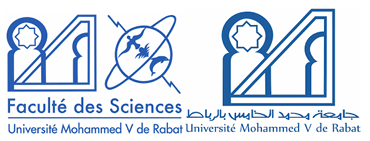

# Détection du cancer du sein à partir de la mammographie par l'utilisation de l'IA.

* ESSAMADI Oussama
* ZOUIR Amine
* CHIBI Mohammed

## Dependencies

In [1]:
!pip install tensorflow==2.12.0

In [2]:
import pickle
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras.callbacks import CSVLogger
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

2025-01-13 15:45:44.309736: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-13 15:45:44.413255: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-13 15:45:44.414582: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-13 15:45:45.820947: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Dataset

### Loading the data

We start by creating an image data generator that will scale each pixel's value by 1/255, essentially normalizing them from the standard 0–255 range to a 0–1 range.
Then we load the three data collections separately.

In [3]:
datagen = ImageDataGenerator(rescale = 1./255)


train = datagen.flow_from_directory('../assets/train/', target_size=(224, 224), class_mode='binary', batch_size=64)
val = datagen.flow_from_directory('../assets/val/', target_size=(224, 224), class_mode='binary', batch_size=64)
test = datagen.flow_from_directory('../assets/test/', target_size=(224, 224), class_mode='binary', batch_size=64)     

Found 3816 images belonging to 2 classes.
Found 1908 images belonging to 2 classes.
Found 1908 images belonging to 2 classes.


### Data inspection

Now we fetch the first batch of images and labels out of `train`, and confirm their shape.

In [4]:
imgs, labels = next(train)
imgs.shape

(64, 224, 224, 3)

* **64**: the batch size (number of images).
* **224 × 224**: the height and width of each image, as defined in `target_size=(224, 224)`.
* **3**: the number of color channels (RGB).

We confirm that we only have 2 classes. **Benign** and **Malgnant**.

In [5]:
train.class_indices

{'benign': 0, 'malignant': 1}

Displaying the first image in the training dataset should show us a grayscale scan of a breast, accompanied with the correct class decided by its diagnosis.

Class: 0.0


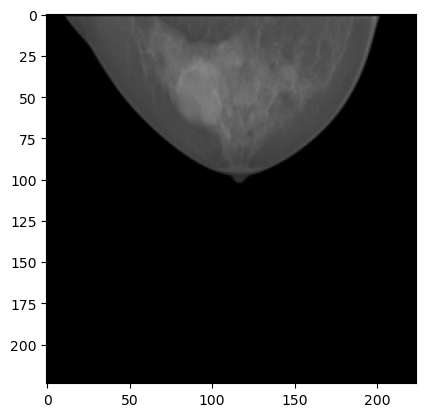

In [6]:
plt.imshow(imgs[0])
print(f'Class: {labels[0]}')

The class is `0.0`, which matches **Benign** on the class indices of the training dataset.

## Model

We're gonna build a simple Convolutional Neural Network (CNN) for binary classification. First, we add three convolution-and-pooling blocks to extract spatial features from the images. Then, we flatten the feature maps and pass them through a couple of dense (fully connected) layers, including a dropout for regularization. Finally, we use a single output neuron with a sigmoid activation for predicting whether an image is benign or malignant.

Step 1:
* We start by initializing a new `Sequential` model, which is a linear stack of layers in Keras.

Step 2:
* `Conv2D(32, (3, 3))`: A convolutional layer with 32 filters/kernels, each 3×3 in size.
* `input_shape=(224,224,3)`: This is the expected shape of the input images. 224×224 resolution, 3 color channels (RGB).
* `activation='relu'`: Uses the ReLU activation function.
* `MaxPooling2D(pool_size=(2, 2))`: Reduces the spatial dimensions by taking the maximum value in each 2×2 pool region, effectively halving the height and width.

Step 3:
* Similar to the first block, but it doesn't need an input_shape since Keras automatically infers the shape from the previous layer's output.
* Another 32 filters, each 3×3, followed by a 2×2 max pool to further downsample.

Step 4:
* Now we increase the number of filters to 64. A larger number of filters can learn more complex features.
* Followed by another 2×2 max pool for further spatial reduction.

Step 5:
* `Flatten()`: Converts the 3D feature maps (height × width × channels) into a 1D vector, so it can be fed into a dense (fully connected) layer.
* `Dense(64, activation='relu')`: A fully connected layer with 64 neurons, learning high-level combinations of features.
* `Dropout(0.5)`: Randomly sets 50% of the neurons to zero during training to reduce overfitting.
* `Dense(1, activation='sigmoid')`: The final output layer. Since this is a binary classification (benign vs. malignant), we use a single neuron with a sigmoid activation, which outputs a probability between 0 and 1.

Step 6:
* `loss='binary_crossentropy'`: The appropriate loss function for binary classification.
* `optimizer='rmsprop'`: A gradient-based optimization algorithm (alternative to Adam, SGD, etc.).
* `metrics=['accuracy']`: We track accuracy during training/evaluation.

In [7]:
# Step 1 - Initializing model
model = Sequential()

# Step 2 - First Convolution + MaxPooling
model.add(Conv2D(32, (3, 3), input_shape=(224,224,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Step 3 - Second Convolution + MaxPooling
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Step 4 - Third Convolution + MaxPooling
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Step 5 - Flatten + Dense + Dropout + Output
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Step 6 - Compile
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

* **Output Shape**: The size of the activation maps after each layer.

* **Param #**: The number of trainable parameters (weights and biases).
> Notice that most of the parameters (over 2.7 million) are in the fully connected layer (dense_6), which converts the flattened feature maps to 64 neurons.

* **Total params**: The sum of all parameters in the network.

## Training

In this step we will train the CNN for 25 epochs while logging metrics to a CSV file (training.log) for analysis, and then saves the trained model for future use.

In [8]:
# Calculating how many batches (steps) makeup one full pass (epoch) through our training and validation datasets.
STEP_SIZE_TRAIN = train.n//train.batch_size
STEP_SIZE_VAL = val.n//val.batch_size

# This callback records loss, accuracy, and other metrics for each epoch into a CSV file named training.log.
# It's helpful for tracking and comparing training progress over time.
csv_logger = CSVLogger('../assets/out/training.log', separator=',', append=False)

history = model.fit_generator(generator = train, 
                    steps_per_epoch=STEP_SIZE_TRAIN, 
                    validation_data=test,
                    validation_steps=STEP_SIZE_VAL,
                    epochs=25,
                    callbacks=[csv_logger])

model.save('../assets/out/model.h5')

Epoch 1/25


/tmp/ipykernel_26949/826499864.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = train,
2025-01-13 15:45:48.444079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


59/59 [==============================] - ETA: 0s - loss: 0.6450 - accuracy: 0.6660

2025-01-13 15:46:49.985151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


59/59 [==============================] - 67s 1s/step - loss: 0.6450 - accuracy: 0.6660 - val_loss: 0.6352 - val_accuracy: 0.6697
Epoch 2/25
59/59 [==============================] - 61s 1s/step - loss: 0.6341 - accuracy: 0.6690 - val_loss: 0.6327 - val_accuracy: 0.6665
Epoch 3/25
59/59 [==============================] - 60s 1s/step - loss: 0.6295 - accuracy: 0.6724 - val_loss: 0.6227 - val_accuracy: 0.6713
Epoch 4/25
59/59 [==============================] - 59s 1s/step - loss: 0.6261 - accuracy: 0.6727 - val_loss: 0.6192 - val_accuracy: 0.6676
Epoch 5/25
59/59 [==============================] - 60s 1s/step - loss: 0.6099 - accuracy: 0.6759 - val_loss: 0.6123 - val_accuracy: 0.6923
Epoch 6/25
59/59 [==============================] - 66s 1s/step - loss: 0.5808 - accuracy: 0.6932 - val_loss: 0.6027 - val_accuracy: 0.6789
Epoch 7/25
59/59 [==============================] - 62s 1s/step - loss: 0.5405 - accuracy: 0.7180 - val_loss: 0.5578 - val_accuracy: 0.7198
Epoch 8/25
59/59 [=============

To determine the step sizes, take note of the following:
* `train.n` and `val.n`: The total number of samples in each dataset.
* `train.batch_size` and `val.batch_size`: The batch size.
* Using integer division `//` gives you the number of batches needed.

As for fitting the model:
* `model.fit_generator(...)`: Trains the model using the data generated from train (the training image generator) in batches.
* `steps_per_epoch=STEP_SIZE_TRAIN`: How many steps (batches) to run per epoch during training.
* `validation_data=test` and `validation_steps=STEP_SIZE_VAL`: Here, you're using the test generator for validation, with STEP_SIZE_VAL batches per epoch.
* `epochs=25`: The number of times the model will see the entire dataset.
* `callbacks=[csv_logger]`: Logs each epoch's metrics to the CSV file.

We can visualize how our model's accuracy changes over the course of training. By plotting both the training and validation accuracy, we'll get a clear picture of how well the model is fitting to the training data and how effectively it generalizes to unseen data.

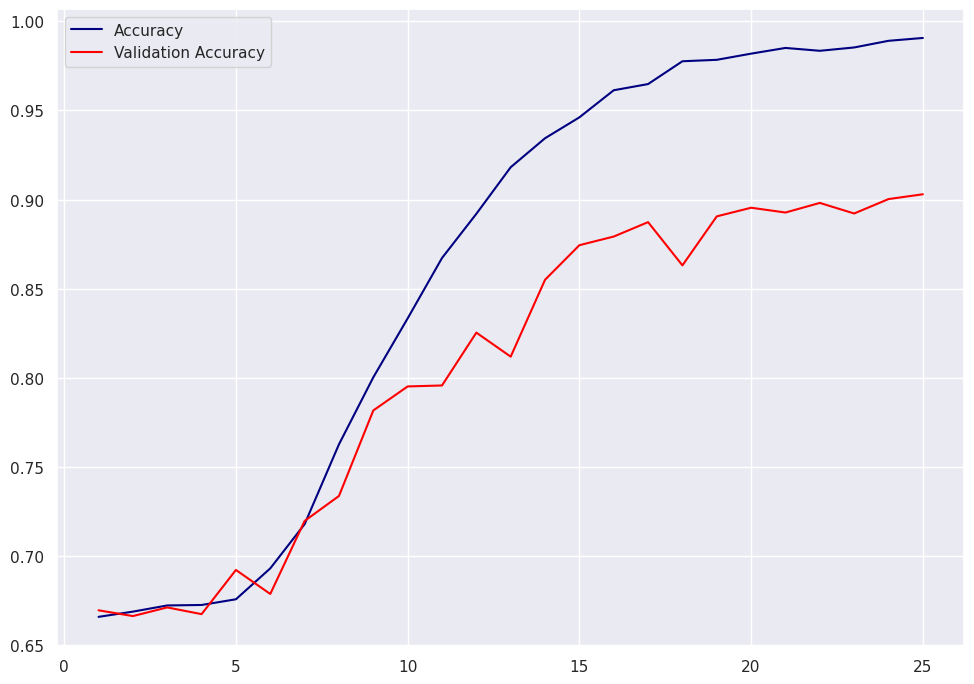

In [9]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

plt.plot(np.arange(1, len(history.history['accuracy'])+1,1), history.history['accuracy'], color='navy', label = 'Accuracy')
plt.plot(np.arange(1, len(history.history['accuracy'])+1,1), history.history['val_accuracy'], color='red', label='Validation Accuracy')
plt.legend()

The plot shows two lines: one for the **training accuracy** (in navy) and another for the **validation accuracy** (in red). As the number of epochs increases, we can observe whether the model converges, if it overfits (training accuracy outpacing validation accuracy), or if both accuracies improve steadily over time. This helps us assess the model's performance and decide on further tuning.

From the plot, we can see that the training accuracy (blue line) reaches near-perfect levels, while the validation accuracy (red line) plateaus around the high 80s to low 90s. This suggests the model is learning effectively but also overfitting somewhat—its performance on unseen data (validation accuracy) isn't as high as on the training set. Even so, the validation accuracy still remains robust, indicating that the model generally performs well at classifying new examples despite not matching the near-perfect training performance.

We can do the same with the saved model.
We can read back the CSV file (training.log) that was generated by the `CSVLogger` during training. Each row in this file corresponds to an epoch, and the columns contain metrics like loss, accuracy, validation loss, and validation accuracy.

In [10]:
log_data = pd.read_csv('../assets/out/training.log', sep=',', engine='python')
log_data.head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.666045,0.645041,0.669720,0.635208
1,1,0.668977,0.634052,0.666487,0.632698
2,2,0.672441,0.629550,0.671336,0.622746
3,3,0.672708,0.626053,0.667565,0.619238
4,4,0.675906,0.609857,0.692349,0.612273


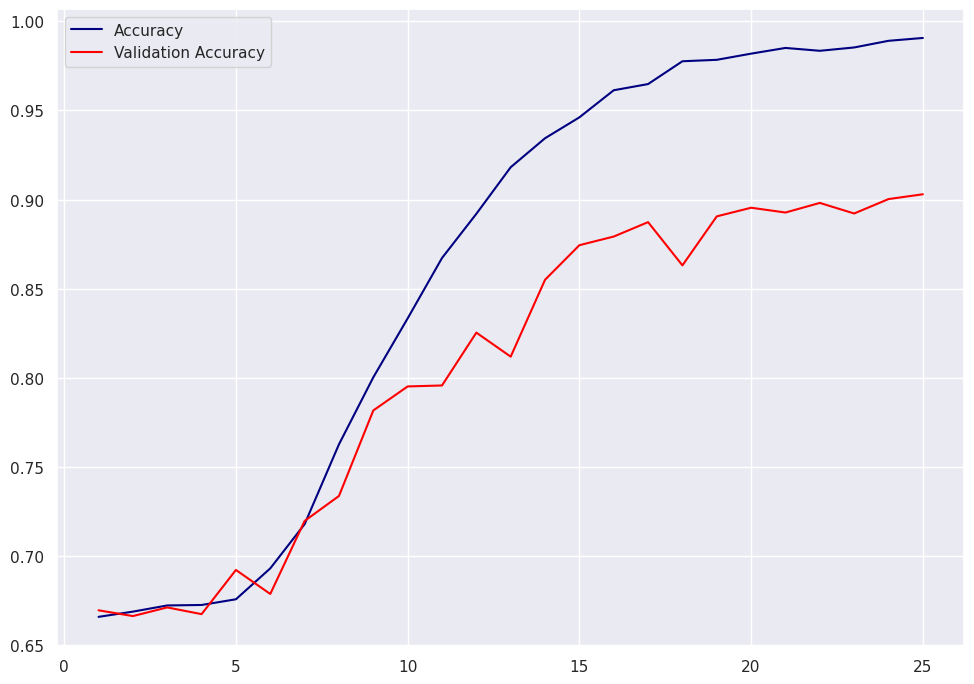

In [11]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

plt.plot(np.arange(1, len(log_data['accuracy'])+1,1), log_data['accuracy'], color='navy', label = 'Accuracy')
plt.plot(np.arange(1, len(log_data['accuracy'])+1,1), log_data['val_accuracy'], color='red', label='Validation Accuracy')
plt.legend()

Again, visualizing how our model's **training loss** (in navy) compares to the **validation loss** (in red) over each epoch of training. By charting both curves, we can spot whether the model is successfully generalizing (both losses decreasing together) or if it begins to overfit (training loss keeps going down while validation loss rises). This step is essential to ensure our model is learning appropriately and to guide further tuning.

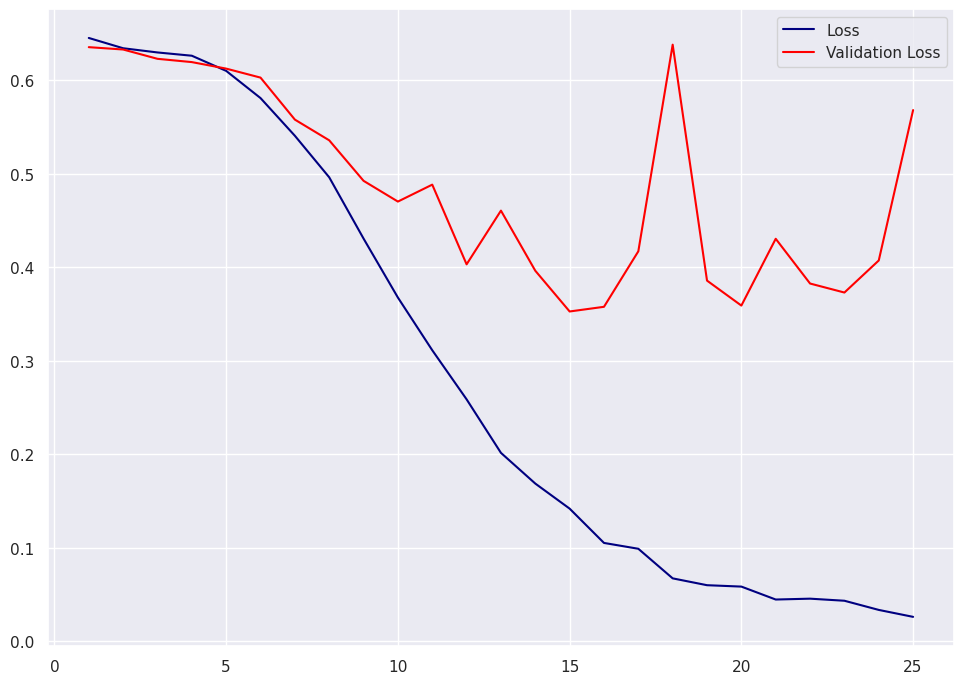

In [12]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

plt.plot(np.arange(1, len(history.history['loss'])+1,1), history.history['loss'], color='navy', label = 'Loss')
plt.plot(np.arange(1, len(history.history['loss'])+1,1), history.history['val_loss'], color='red', label='Validation Loss')
plt.legend()

From this plot, it's clear that the **training loss** (blue) steadily goes down to very low values, indicating the model is fitting the training data extremely well. However, the **validation loss** (red) varies up and down rather than following the same steady downward trend, suggesting the model is **overfitting** and not generalizing as consistently to unseen data. The spikes in the validation loss can occur for various reasons (e.g., data variability, small validation sets, or model instability), but the key takeaway is that while the model memorizes the training set effectively, its performance on new data is less stable.

Doing the same again with the logged data.

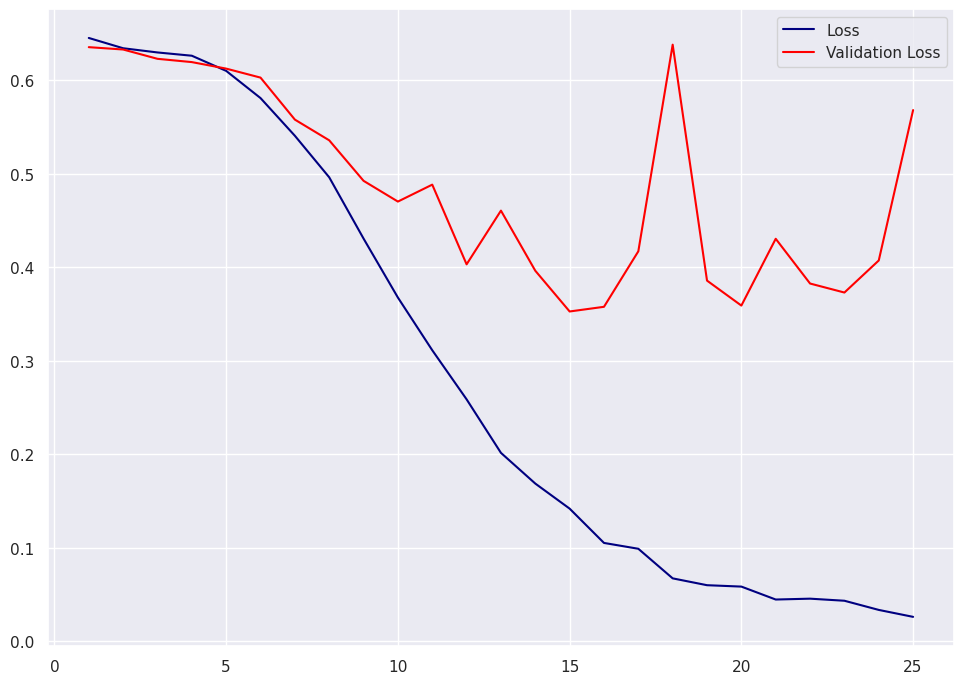

In [13]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

plt.plot(np.arange(1, len(log_data['loss'])+1,1), log_data['loss'], color='navy', label = 'Loss')
plt.plot(np.arange(1, len(log_data['loss'])+1,1), log_data['val_loss'], color='red', label='Validation Loss')
plt.legend()

## Hibernation

We can load our previously saved model from disk, then extract all the images and labels from our test generator into NumPy arrays. This prepares our entire test set in a convenient format for further evaluation or predictions.

In [14]:
# Loading the previously saved model from the specified path. This includes the architecture, weights, and training configuration (if any).
restored_model = load_model('../assets/out/model.h5')

# Calculating how many batches you need to go through in order to cover our entire test set
steps = test.n//test.batch_size

# Reseting the test generator to start yielding batches from the first image again. This is useful if the generator's internal index was advanced by previous calls (e.g., during validation).
test.reset()

# Collecting the test data
X_test, y_test = [], []
for i in range(steps):
    a , b = test.next()
    X_test.extend(a) 
    y_test.extend(b)

# Converting lists to NumPy arrays
X_test, y_test = np.array(X_test), np.array(y_test)

We can save our test data arrays (X_test and y_test) to disk using `pickle.dump` and then reload them with `pickle.load`.

In [15]:
# Pickling the model
pickle.dump(X_test, open('../assets/out/X_test.pkl', 'wb'))
pickle.dump(y_test, open('../assets/out/y_test.pkl', 'wb'))

# Reloading the model to ensure not thing is corrupt
X_test = pickle.load(open('../assets/out/X_test.pkl', 'rb'))
y_test = pickle.load(open('../assets/out/y_test.pkl', 'rb'))

print(X_test.shape, y_test.shape)

(1856, 224, 224, 3) (1856,)


* `pickle.dump(...)`: Serializes (saves) Python objects to a file in a binary format.
* `'wb'`: Means write binary.
* `pickle.load(...)`: Deserializes (loads) the data back from the pickle files into memory.
* `'rb'`: Means read binary.

Result:
* **(1856, 224, 224, 3)**: There are 1856 images, each 224×224 pixels in size with 3 color channels (RGB).
* **(1856,)**: The corresponding labels array for these images has 1856 labels.

## Evaluation

We can evaluate the trained model on the full test dataset (`X_test`, `y_test`) and print its performance metrics. Specifically, we `model.evaluate(...)` to obtain the final **loss** and **accuracy** on unseen data, giving us a measure of how well our model generalizes beyond the training set.

### Evaluating the model

In [16]:
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.5697688460350037 / Test accuracy: 0.9024784564971924


The above function runs the model on the test data (`X_test` and corresponding labels `y_test`) and returns a list (or tuple) of metrics. In this case, because our model was compiled with `loss='binary_crossentropy'` and `metrics=['accuracy']`, `score[0]` will be the test loss and `score[1]` will be the test accuracy. `verbose=0` means it will not print any progress bar or additional information during evaluation.

Test loss is about **0.5955**, which is a moderate number (lower is typically better).
Test accuracy is about **0.9024**, suggesting our model correctly classifies around **90%** of the test samples. This indicates a solid performance on this binary classification task.

### Evaluating the saved model

In [17]:
score = restored_model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.5697688460350037 / Test accuracy: 0.9024784564971924


Evidently, the saved model would yeild the same results.

## Prediction

We can use our trained model to generate predicted probabilities for each image in the test set. Since this is a binary classification problem, each number represents the model's estimated likelihood that the image belongs to class **1** (the **Malignant** class).

### Prediction with the model

In [18]:
y_pred_prob = model.predict(X_test)
print(y_pred_prob)

58/58 [==============================] - 4s 74ms/step
[[0.9999859 ]
 [0.04050295]
 [0.9999999 ]
 ...
 [1.        ]
 [1.        ]
 [0.999999  ]]


### Prediction with the saved model

In [19]:
y_pred_prob = restored_model.predict(X_test)
print(y_pred_prob)

58/58 [==============================] - 5s 81ms/step
[[0.9999859 ]
 [0.04050295]
 [0.9999999 ]
 ...
 [1.        ]
 [1.        ]
 [0.999999  ]]


Let's plot two sets of points for each test sample (indexed on the x-axis):
* `y_pred_prob` (red dots): These are the predicted probabilities for each sample. A value near 1 indicates the model believes the image is likely in class **1** (**Malignant**), and a value near 0 indicates the model thinks it's class **0** (**Bengin**).
* `y_test` (blue dots): These are the actual labels (ground truth), which are 0 or 1 in a binary classification. Here, each blue dot at the top represents an actual label of "1" while each blue dot along the bottom represents "0"

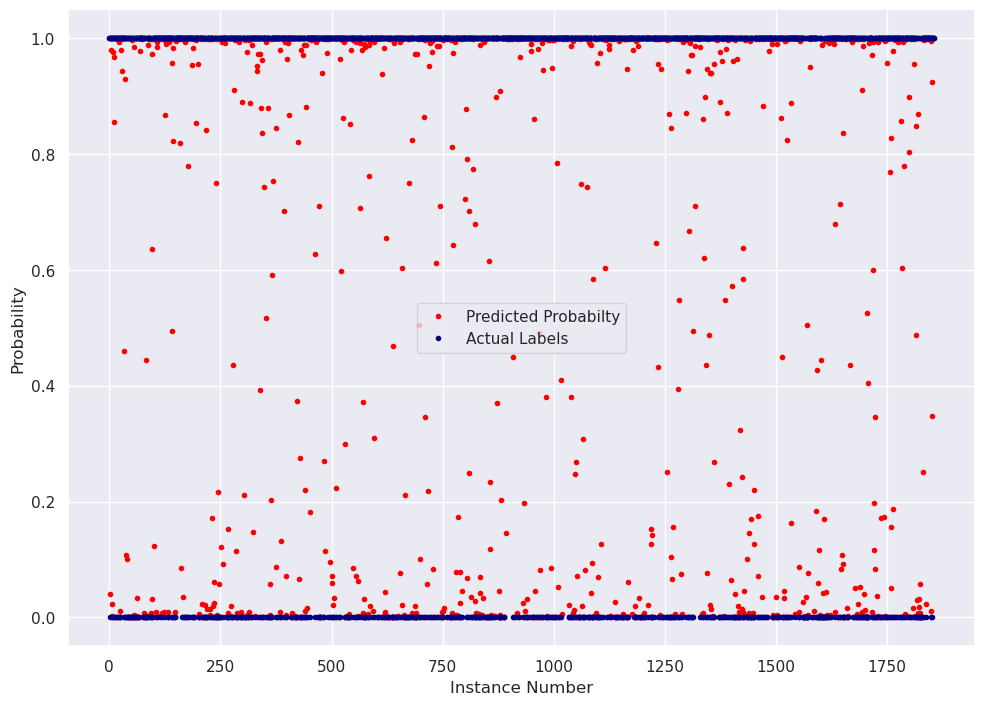

In [20]:
plt.plot(y_pred_prob,'.', color='red', label='Predicted Probabilty')
plt.plot(y_test, '.', color='navy', label='Actual Labels')
plt.xlabel('Instance Number')
plt.ylabel('Probability')
plt.legend()

### Thresholding

Inspecting the Ground Truth Labels:

In [21]:
y_test

array([1., 0., 1., ..., 1., 1., 1.], dtype=float32)

Let's apply a threshold of **0.5** on the model's predicted probabilities to get final class predictions `y_pred`.

In [22]:
threshold = 0.5

y_pred = np.where(y_pred_prob > threshold, 1 ,0)
y_pred.squeeze

y_pred   

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [1]])

* `threshold = 0.5`: We choose 0.5 as the cutoff. If the predicted probability `y_pred_prob` is above 0.5, we predict class 1, otherwise class 0. This is the standard threshold for binary classification when using a sigmoid output layer.
* `np.where(y_pred_prob > threshold, 1, 0)`: Converts the continuous probabilities into discrete class predictions (0 or 1).
* `y_pred.squeeze()`: Removes extra dimensions if present (e.g., if `y_pred` is of shape (N, 1) instead of (N,)).
* `y_pred`: Now contains integer class predictions for each sample—either 0 or 1.

## Analysis

We can visualize the Confusion Matrix as a Heatmap to help us quickly assess the performance of your model, whether it's correctly predicting malignant and benign cases, and how often it makes misclassifications in each direction.

Text(0.5, 1.0, 'Confusion Metrix for Breast Cancer')

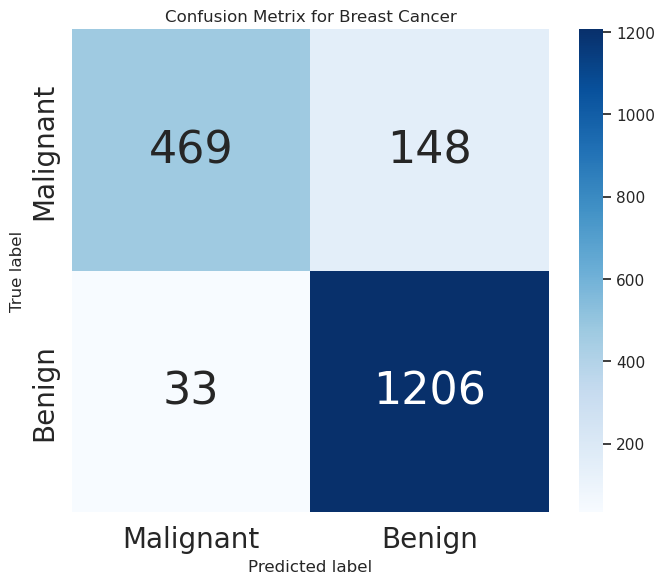

In [23]:
sns.set(rc={'figure.figsize':(7.7,6.27)})
sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, annot=True, annot_kws={"size": 32}, fmt='g')

plt.xticks([0.50,1.50], ['Malignant','Benign'], fontsize=20)
plt.yticks([0.50,1.50],['Malignant','Benign'], fontsize=20)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Metrix for Breast Cancer')

From the above, we see that out of **617 malignant** samples (top row), the model correctly identifies **469** as malignant but misclassifies **148** as benign. For the **1239 benign** samples (bottom row), **1206** are correctly predicted as benign, with **33** mistakenly labeled as malignant. Overall, the model does a good job classifying benign cases (low false positives) but still misses some malignant cases (119 false negatives). In a medical context, those false negatives are critical because they represent malignant tumors misdiagnosed as benign. Nonetheless, the overall accuracy is high, indicating strong performance on the dataset.

In [24]:
print(classification_report(y_test, y_pred, target_names = ['Benign (Class 0)','Malignant (Class 1)']))

                     precision    recall  f1-score   support

   Benign (Class 0)       0.93      0.76      0.84       617
Malignant (Class 1)       0.89      0.97      0.93      1239

           accuracy                           0.90      1856
          macro avg       0.91      0.87      0.88      1856
       weighted avg       0.91      0.90      0.90      1856



* **Precision**: Measures how many of the samples predicted as a certain class (e.g., **Malignant**) actually belong to that class.
* **Recall**: (Also known as sensitivity) measures how many of the samples belonging to a certain class (e.g., **Malignant**) are correctly identified.
* **F1 score**: The harmonic mean of precision and recall. It balances both metrics into one number.
* **Support**: The number of samples in the dataset belonging to each class.
* **Accuracy**: The proportion of all samples (both positive and negative) that were correctly classified.
* **Macro avg**: The metric (e.g., precision, recall, F1) independently for each class, and then takes the average. This treats all classes equally.
* **Weighted avg**: The metric (e.g., precision, recall, F1) for each class and weights them by the number of samples from that class.
​
 


The model does particularly well identifying malignant tumors (high recall of 0.97). This is typically desirable in a medical setting, because missing malignant cases (false negatives) can be more critical.
However, the recall for benign cases is lower (0.84), meaning some benign samples are misclassified as malignant. Overall, the model is still quite strong in distinguishing the two classes, as shown by an F1-score above 0.93 for malignant and 0.84 for benign.

If we generate an ROC curve by comparing the model's predicted probabilities `y_pred_prob` against the true labels `y_test` at various decision thresholds we can calculate the false positive rate (FPR) and true positive rate (TPR) for each threshold and then plot them.

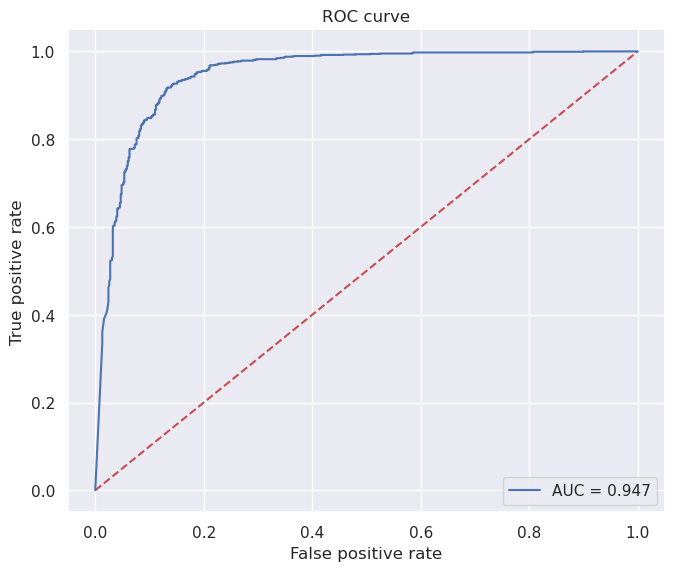

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
area_under_curve = auc(fpr, tpr)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

plt.show()

The AUC (Area Under the Curve) of 0.947 shows that our model has strong discriminatory power—it can distinguish malignant from benign cases accurately across a broad range of thresholds. The closer the AUC is to 1.0, the better the model's overall performance.

Now, let's sample 25 random test images from the dataset `X_test`.
For each image we'll retrieve:
1. The predicted class (either 0 or 1) and mapped it to "Benign" or "Malignant".
2. The model's probability for that predicted class.

In [84]:
# mapping numeric predictions (0 or 1) to the corresponding string labels.
cancer_labels = ['Benign', 'Malignant']

# Randomly picking 25 indices from the test set, then retrieving those images.
img_indices = np.random.randint(0, len(X_test), size=25)
sample_test_images = X_test[img_indices]

# Creatinng a list of predicted labels (e.g., "Benign" or "Malignant") corresponding to each of the chosen images.
actual_test_labels = [cancer_labels[int(label)] for label in y_test[img_indices]]

max_prediction = np.max(y_pred_prob, axis=1)
prediction_probs = np.max(y_pred_prob, axis=1)

* `max_prediction`: For each test sample, takes the index of the highest probability. (In a binary classification with one output neuron, this step usually isn't necessary—if you had two output neurons, it picks whichever neuron has the higher probability.)
* `prediction_probs`: Grabs the actual probability value of that highest-probability class.

We then display each image in a subplot, labeling it with the predicted class and its predicted probability on the x-axis, and (in this snippet) also showing the predicted label again on the y-axis.

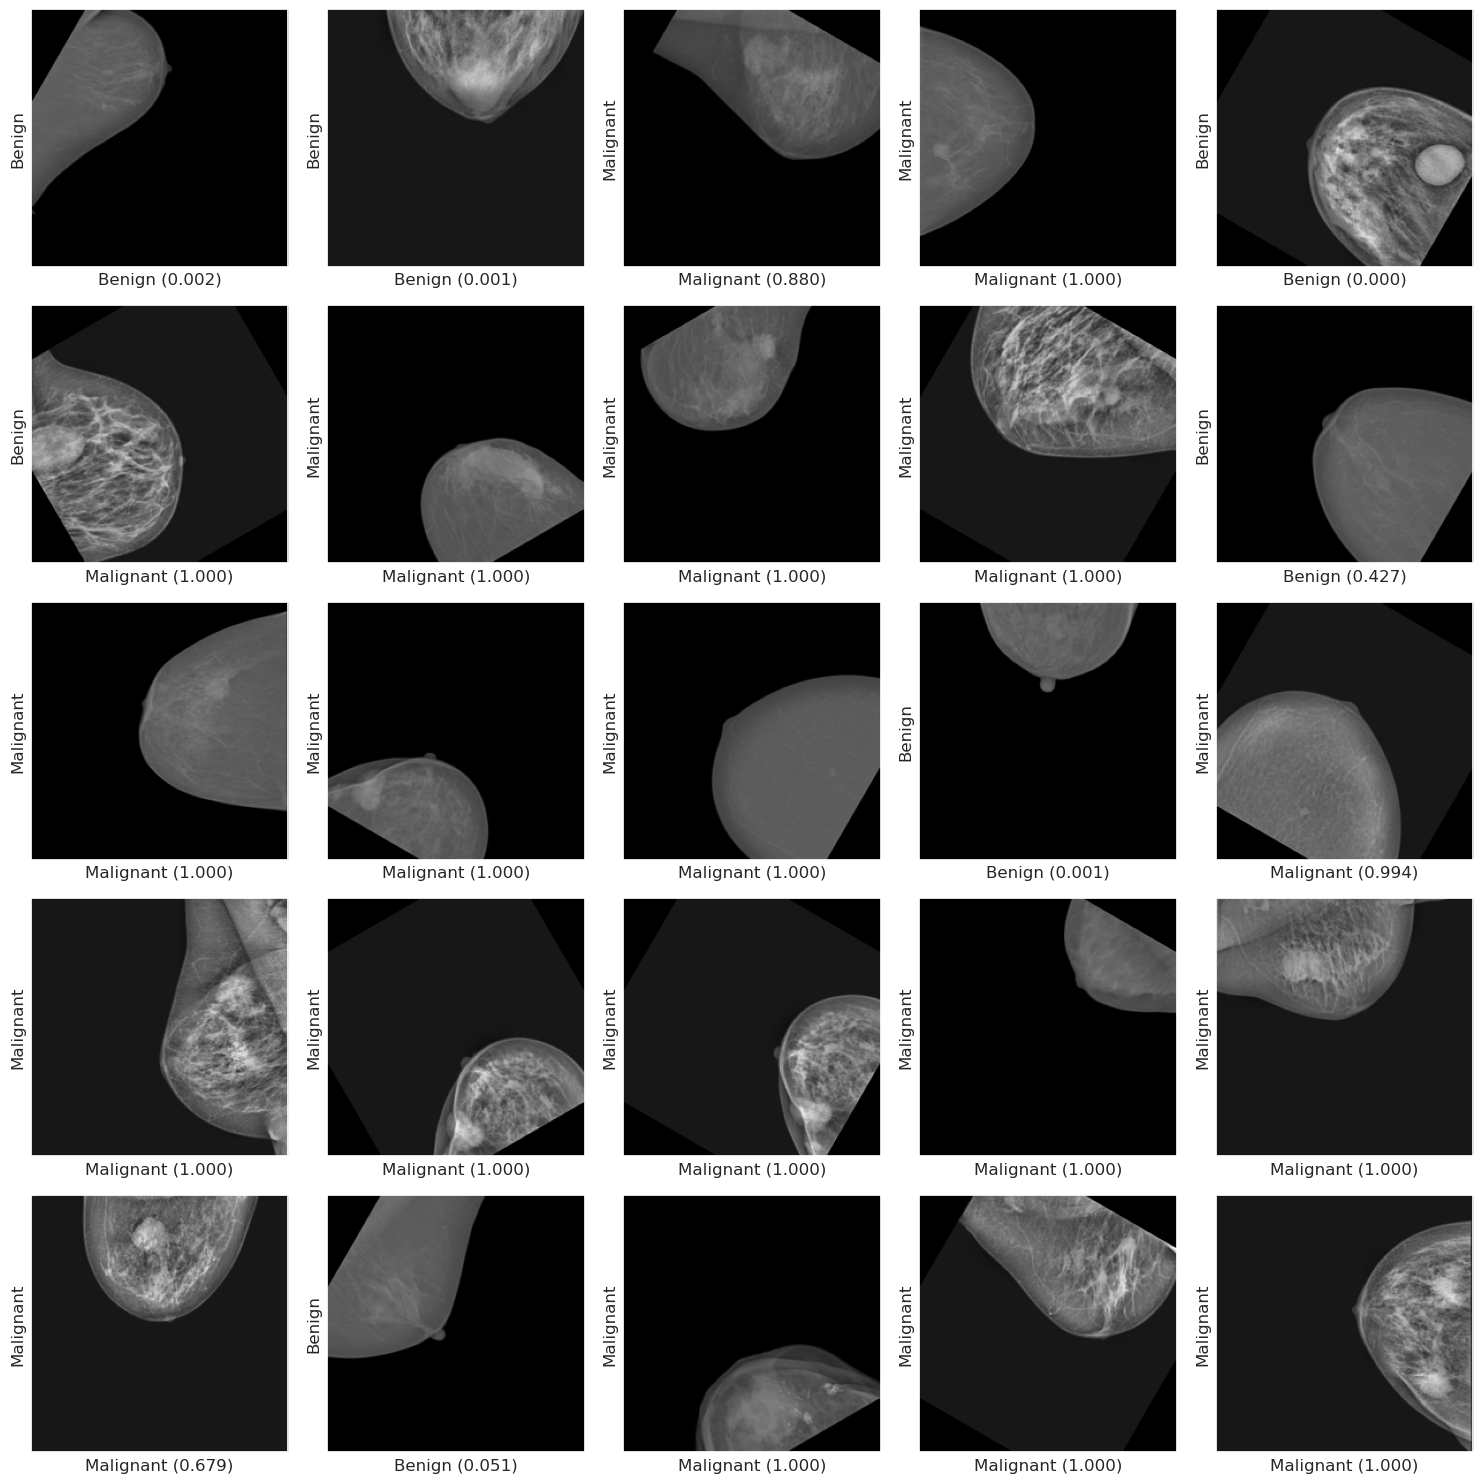

In [87]:
plt.figure(figsize=(15,15))

for i, (img, pred_idx, prob, true_label) in enumerate(
    zip(sample_test_images, max_prediction[img_indices], 
        prediction_probs[img_indices], actual_test_labels)
):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(img)
    plt.xlabel(f"{cancer_labels[int(round(pred_idx))]} ({prob:.3f})")
    plt.ylabel(true_label)

plt.tight_layout()
plt.show()

By visually inspecting these images, you can see how confident the model is for each prediction.
If "Benign" images mostly have predicted probabilities close to 1.0 for "Benign", and "Malignant" images similarly have high probabilities for "Malignant" the model is performing well.
In the provided screenshot, most if not all predicted labels and confidence levels appear correct or strongly confident. However, any discrepancies (e.g., a visually "Malignant" image labeled as "Benign" with a high probability) would signal a misclassification worth investigating.